# LTSM with Atttention

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


## Data

In [3]:
import os
from google.colab import drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
folder_path = '/content/drive/My Drive/news_classifier/'
file_list = os.listdir(folder_path)

In [7]:
file_name = 'data_texts_pt.csv'
full_path = os.path.join(folder_path, file_name)
data_texts = pd.read_csv(full_path)

In [8]:
file_name = 'data_labels_pt.csv'
full_path = os.path.join(folder_path, file_name)
data_labels = pd.read_csv(full_path)

## Preprocessing the Data

In [24]:
data_texts

,0
0,Mais de 4 milhões de americanos enrolam mangas...
1,"O Flyer da American Airlines cobrou, banido po..."
2,Mulher que chamou policiais em Black Bird-Watc...
3,O limpador estava morto no banheiro de Belk po...
4,Repórter fica adorável surpresa do namorado en...
...,...
30213,A Cúpula Global mira o Mistério Ultimate: o cé...
30214,Por que '13 razões por que' não deveria ser a ...
30215,Como a poluição do ar entra na corrente sanguí...
30216,O cérebro de Aaron Hernandez será estudado par...


In [27]:
data_texts = data_texts['0'].str.lower()

In [31]:
data_labels = data_labels['categoria'].str.lower()

In [33]:
# slipt the data into training (train_text) and testing (test_text)
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(data_texts, data_labels, test_size=0.2, random_state=29)

### Stop Words Removal and Lemmatization


In [ ]:
import spacy

!python -m spacy download pt_core_news_lg

In [ ]:
nlp = spacy.load("pt_core_news_lg")

def preprocess_text(text):
    doc = nlp(text.lower())
    filtered_words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(filtered_words)

In [ ]:
x_train = x_train['0'].apply(preprocess_text)
x_val = x_val['0'].apply(preprocess_text)

### Tokenization

In [34]:
# maximum number of tokens
TOK_MAX = 20000

In [35]:
# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 300

In [36]:
from keras.layers import TextVectorization

def tokenization(train_texts, val_texts):
    max_length = len(max(train_texts, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    vectorize_layer = TextVectorization(
        max_tokens=TOK_MAX,
		    output_mode='int',
		    output_sequence_length=max_length)

	# Call adapt on the training texts
    vectorize_layer.adapt(train_texts)
    x_train = vectorize_layer(train_texts)
    x_val = vectorize_layer(val_texts)

	#get the word index
    vocab = vectorize_layer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))

    return x_train, x_val, word_index

In [37]:
x_train, x_val, word_index = tokenization(x_train, x_val)

In [38]:
x_train.shape

TensorShape([24174, 300])

### Encode the labels into integers

In [39]:
# encode the labels
from sklearn.preprocessing import LabelEncoder

def encode_label(train_labels, val_labels):
    """Encodes training and validation labels and returns a dictionary mapping labels to codes.

	# Arguments
		train_labels: list, training labels.
		val_labels: list, validation labels.

	# Returns
		y_train, y_val, label_mapping: encoded labels and a dictionary mapping labels to codes.
	"""
    encoder = LabelEncoder()
    encoder.fit(train_labels)
    y_train = encoder.transform(train_labels)
    y_val = encoder.transform(val_labels)

    label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

    return y_train, y_val, label_mapping

In [40]:
y_train, y_val, label_mapping = encode_label(y_train, y_val)

In [41]:
label_mapping

{'actualidade': 0,
 'ambiente': 1,
 'bem-estar': 2,
 'casa & vida': 3,
 'celebridades': 4,
 'ciência': 5,
 'comida & bebida': 6,
 'comédia': 7,
 'crime': 8,
 'cultura & artes': 9,
 'desporto': 10,
 'dinheiro': 11,
 'educação': 12,
 'entretenimento': 13,
 'estilo & beleza': 14,
 'impacto': 15,
 'meia idade': 16,
 'meios de comunicação': 17,
 'mulher': 18,
 'negócios': 19,
 'notícias do mundo': 20,
 'notícias estranhas': 21,
 'parentalidade': 22,
 'política': 23,
 'religião': 24,
 'tecnologia': 25,
 'verde': 26,
 'viagens': 27,
 'vida saudável': 28}

## Building, Training, and Evaluating the Model


####GloVe

In [42]:
file_name = 'glove_s300.txt'
full_path = os.path.join(folder_path, file_name)

In [43]:
embeddings_index = {}

def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False

with open(full_path, encoding='utf-8') as f:
    for line in f:
        values = line.replace(',', '.').split()
        word = values[0]
        # Check if all elements can be converted to float
        if all(is_float(v) for v in values[1:]):
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
        else:
            print(f"Skipping line: {line}")

print('Total %s word vectors.' % len(embeddings_index))

Skipping line: 00 % -0.040023 -0.002672 -0.022858 0.260644 -0.017643 0.001173 -0.068368 0.048179 -0.018346 -0.009830 0.093557 0.053164 0.061118 -0.056703 0.024302 0.053458 -0.142352 0.031597 -0.055382 -0.022695 0.014720 0.026441 -0.002465 0.054266 0.048117 -0.003321 -0.097339 0.002167 0.090516 -0.085564 0.041040 0.031038 -0.014851 -0.007635 -0.017377 0.079232 0.042513 -0.061471 0.140850 0.044054 0.029572 -0.089555 0.065983 0.007121 0.043298 0.106403 -0.061894 -0.027963 0.013746 0.145442 0.066288 0.023571 0.096237 0.027561 -0.065272 0.187776 0.002649 -0.107769 0.053745 0.024152 0.042198 0.070686 -0.005959 0.179837 0.044830 0.017814 -0.001553 -0.023306 -0.067288 0.049581 0.032340 0.005777 0.049695 0.066404 -0.030094 0.099784 0.088351 0.187100 -0.035177 -0.010672 -0.116715 0.055017 -0.078796 0.093464 -0.065208 0.005161 -0.122170 -0.180093 0.120717 -0.020808 0.033636 -0.024732 0.008585 -0.065151 -0.090832 -0.066617 0.052820 0.000154 -0.016564 -0.080445 0.004378 -0.068553 -0.039122 0.083742

In [44]:
print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 20000 unique tokens.
Total 928639 word vectors.


In [45]:
embeddings_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embeddings_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Ensure the embedding_vector is of the correct shape (300,)
        embedding_matrix[i] = embedding_vector[:embeddings_dim]

### LSTM with Attention

In [46]:
from keras import initializers, regularizers, constraints
from keras.layers import Layer
from keras import backend as K

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        super(Attention, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = tf.reshape(tf.linalg.matmul(tf.reshape(x, (-1, features_dim)),
                              tf.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = tf.math.tanh(eij)

        a = tf.math.exp(eij)

        if mask is not None:
            a *= tf.cast(mask, tf.float32)

        a /= tf.cast(tf.reduce_sum(a, axis=1, keepdims=True) + K.epsilon(), tf.float32)

        a = tf.expand_dims(a, axis=1)
        weighted_input = x * a
        return tf.reduce_sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [47]:
from keras.layers import LSTM, BatchNormalization, Embedding, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.initializers import Constant
from keras.models import Model

def lstm_model(lstm_units, dropout_rate, dense_units, learning_rate=0.001):
    embedding_layer = Embedding(input_dim=len(word_index) + 1,
                                output_dim=embeddings_dim,
                                embeddings_initializer=Constant(embedding_matrix),
                                trainable=True,
                                name='embedding_layer')

    lstm_layer = LSTM(
        units=lstm_units,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        return_sequences=True,
        name='lstm_layer'
    )

    model_input = Input(shape=(x_train.shape[1],), name='model_input')

    embedding = embedding_layer(model_input)

    lstm_output = lstm_layer(embedding)
    lstm_output = Dropout(dropout_rate, name='lstm_dropout')(lstm_output)

    attention_output = Attention(x_train.shape[1], name='attention_layer')(lstm_output)

    dense_output = Dense(dense_units, activation='relu', name='dense_layer')(attention_output)
    dense_output = Dropout(dropout_rate)(dense_output)
    dense_output = BatchNormalization(name='batch_normalization')(dense_output)

    model_output = Dense(29, activation='softmax')(dense_output)

    model = Model(inputs=model_input, outputs=model_output, name='lstm_attention_model')

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model

In [48]:
# MAX_SEQUENCE_LENGTH = 300
lstm_model_test = lstm_model(300, 0.25, 256)

In [49]:
lstm_model_test.summary()

Model: "lstm_attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 300)]             0         
                                                                 
 embedding_layer (Embedding  (None, 300, 300)          6000300   
 )                                                               
                                                                 
 lstm_layer (LSTM)           (None, 300, 300)          721200    
                                                                 
 lstm_dropout (Dropout)      (None, 300, 300)          0         
                                                                 
 attention_layer (Attention  (None, 300)               600       
 )                                                               
                                                                 
 dense_layer (Dense)         (None, 256)      

In [50]:
history_test = lstm_model_test.fit(x_train, y_train, batch_size=32, epochs=6, validation_data=(x_val, y_val))

Epoch 1/6
756/756 [==============================] - 599s 783ms/step - loss: 2.0708 - acc: 0.4044 - val_loss: 1.7327 - val_acc: 0.4871
Epoch 2/6
756/756 [==============================] - 584s 773ms/step - loss: 1.3450 - acc: 0.6020 - val_loss: 1.4999 - val_acc: 0.5726
Epoch 3/6
756/756 [==============================] - 576s 762ms/step - loss: 0.9477 - acc: 0.7180 - val_loss: 1.6901 - val_acc: 0.5536
Epoch 4/6
756/756 [==============================] - 580s 768ms/step - loss: 0.6286 - acc: 0.8082 - val_loss: 1.7554 - val_acc: 0.5730
Epoch 5/6
756/756 [==============================] - 577s 763ms/step - loss: 0.3894 - acc: 0.8784 - val_loss: 2.0618 - val_acc: 0.5592
Epoch 6/6
756/756 [==============================] - 576s 763ms/step - loss: 0.2373 - acc: 0.9246 - val_loss: 2.4429 - val_acc: 0.5682


In [53]:
def plot_graphs(history, string):
	plt.plot(history.history[string])
	plt.plot(history.history['val_'+string])
	plt.xlabel("Epochs")
	plt.ylabel(string)
	plt.legend([string, 'val_'+string])
	plt.show()

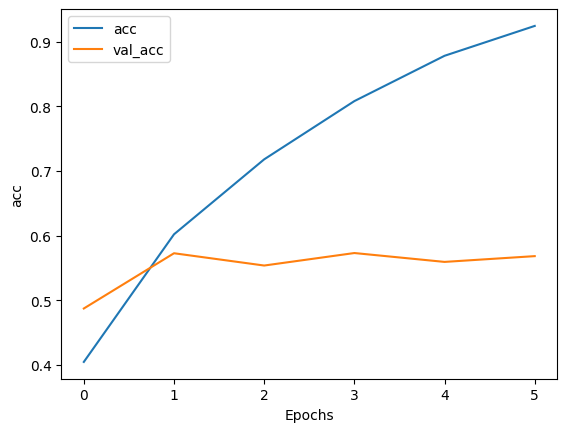

In [54]:
plot_graphs(history_test, "acc")

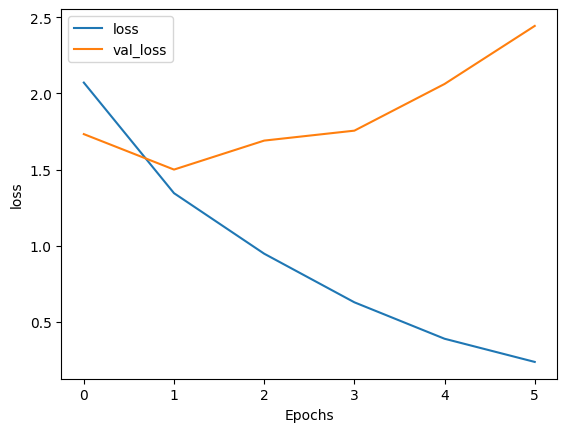

In [55]:
plot_graphs(history_test, "loss")

In [51]:
lstm_model_test_2 = lstm_model(300, 0.25, 256)
lstm_model_test_2.summary()

Model: "lstm_attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 300)]             0         
                                                                 
 embedding_layer (Embedding  (None, 300, 300)          6000300   
 )                                                               
                                                                 
 lstm_layer (LSTM)           (None, 300, 300)          721200    
                                                                 
 lstm_dropout (Dropout)      (None, 300, 300)          0         
                                                                 
 attention_layer (Attention  (None, 300)               600       
 )                                                               
                                                                 
 dense_layer (Dense)         (None, 256)      

In [52]:
history_test_2 = lstm_model_test_2.fit(x_train, y_train, batch_size=128, epochs=6, validation_data=(x_val, y_val))

Epoch 1/6
189/189 [==============================] - 156s 807ms/step - loss: 2.1888 - acc: 0.3675 - val_loss: 2.9894 - val_acc: 0.2737
Epoch 2/6
189/189 [==============================] - 144s 763ms/step - loss: 1.5182 - acc: 0.5540 - val_loss: 2.2949 - val_acc: 0.5195
Epoch 3/6
189/189 [==============================] - 138s 730ms/step - loss: 1.1779 - acc: 0.6478 - val_loss: 1.5578 - val_acc: 0.5591
Epoch 4/6
189/189 [==============================] - 138s 732ms/step - loss: 0.9074 - acc: 0.7223 - val_loss: 1.5925 - val_acc: 0.5615
Epoch 5/6
189/189 [==============================] - 137s 724ms/step - loss: 0.6709 - acc: 0.7945 - val_loss: 1.5981 - val_acc: 0.5865
Epoch 6/6
189/189 [==============================] - 138s 732ms/step - loss: 0.4705 - acc: 0.8518 - val_loss: 1.9325 - val_acc: 0.5695


In [60]:
model_path = '/content/drive/My Drive/news_classifier/lstm_model_pt.keras'
lstm_model_test.save(model_path)

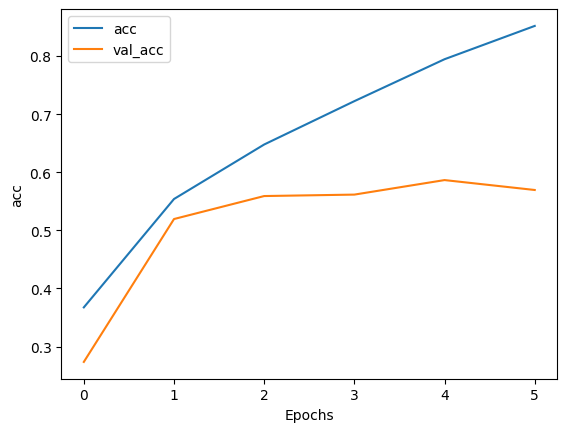

In [56]:
plot_graphs(history_test_2, "acc")

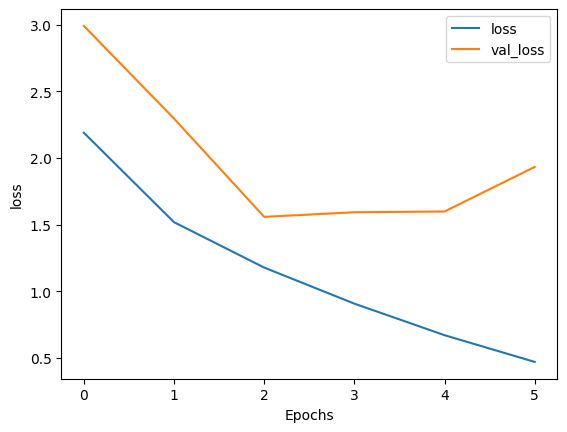

In [57]:
plot_graphs(history_test_2, "loss")

### Tune the hyperparameters

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
from keras_tuner import RandomSearch

def tune_model(hp):
    #hyperparameters
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    dense_units = hp.Int('dense_units', min_value=32, max_value=512, step=32)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = lstm_model(300, dropout_rate, dense_units, learning_rate)

    return model

In [ ]:
tuner = RandomSearch(
    tune_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='lstm_tuning'
)

In [ ]:
# MAX_SEQUENCE_LENGTH = 300
lstm_model_D = lstm_model(300, 0.25)

In [ ]:
lstm_model_D.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 300, 200)       │    10,675,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 300, 300)       │       601,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 300)            │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,363,133 (43.35 MB)

 Trainable params: 11,362,621 (43.34 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
history_D = lstm_model_D.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - acc: 0.2121 - loss: 2.7274 - val_acc: 0.4111 - val_loss: 2.7571
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - acc: 0.5093 - loss: 1.6480 - val_acc: 0.5580 - val_loss: 1.6531
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - acc: 0.6081 - loss: 1.3070 - val_acc: 0.5993 - val_loss: 1.3524
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - acc: 0.6764 - loss: 1.0588 - val_acc: 0.6178 - val_loss: 1.3298
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - acc: 0.7255 - loss: 0.8824 - val_acc: 0.6213 - val_loss: 1.3631
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - acc: 0.7869 - loss: 0.6915 - val_acc: 0.6314 - val_loss: 1.3769
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - acc: 0.8308 - loss: 0.5383 - val_acc: 0.6286 - val_loss: 1.4646
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - acc: 0.8765 - loss: 0.4051 - val_acc: 0.6269 - val_loss: 1.5388
Epoch 9/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/

In [ ]:
# MAX_SEQUENCE_LENGTH = 300 and dropout = 0.3
lstm_model_F = lstm_model(300, 0.3)

In [ ]:
lstm_model_F.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 300, 200)       │     4,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 300, 300)       │       601,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 300, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (Attention)         │ (None, 300)            │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,688,047 (17.88 MB)

 Trainable params: 4,687,535 (17.88 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
history_F = lstm_model_F.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - acc: 0.0601 - loss: 3.3739 - val_acc: 0.0777 - val_loss: 3.2952
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - acc: 0.1201 - loss: 3.0191 - val_acc: 0.2011 - val_loss: 2.9161
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - acc: 0.2227 - loss: 2.5828 - val_acc: 0.3414 - val_loss: 2.2623
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - acc: 0.3815 - loss: 2.0599 - val_acc: 0.4321 - val_loss: 1.9139
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - acc: 0.5018 - loss: 1.6749 - val_acc: 0.4957 - val_loss: 1.7361
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - acc: 0.5856 - loss: 1.3752 - val_acc: 0.5116 - val_loss: 1.7319
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - acc: 0.6456 - loss: 1.1708 - val_acc: 0.5368 - val_loss: 1.7005
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - acc: 0.7003 - loss: 0.9803 - val_acc: 0.5381 - val_loss: 1.7065
Epoch 9/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/